# Final Project
## Part 2: Classifying Kazakhstan's News Sources
Author: Malika Parkhomchuk

### Tasks:
1. Manually identify independent and government-funded sources and get their twitter ids
2. Get followers of each news source using the Paginator
3. Create a function that calculated the Jaccard Index of followers of two sources to determine their similarity
4. Implement this function to find the Jaccard Index between every source and create a 23x23 matrix
5. Build an unsupervided model accroding to the matrix
6. Analyze the results

### Task 1: Manually identify independent and government-funded sources

I used wikipedia to search for each news source that I used in this project in order to find out who edits them and who does it belong to. The independent sources that I was able to gather were indeed independent and some of them are led by prominent civil activists. The government-funded sources are owned by ex or current government officials and huge corporations.

I used Twitter API to get twitter ids of the sources, but the process was manual.

It was hard to get more sources, because I couldn't find more information on other resources. So I chose not to include them in my research.

### Modification:
In the first part I was able to identify popular news sources according to Twitter posts, and I have included them in the sources below. However, that number was too small, so I searched for other popular news sources on my own.

In [2]:
independent_sources = ['https://twitter.com/AzattyqRadiosy', 'https://twitter.com/vlastkz',
                       'https://twitter.com/fctchckKZ', 'https://twitter.com/mediazona_ca',
                      'https://twitter.com/villagekz', 'https://twitter.com/masamediakz',
                       'https://twitter.com/oyanqazaqstankz', 'https://twitter.com/TilZhoq',
                       'https://twitter.com/Minberkz', 'https://twitter.com/zanamiviehali',
                       'https://twitter.com/Rukh2k19', 'https://twitter.com/SFKazakhstan',
                       'https://twitter.com/Radio_Azattyk'
                      ]

In [3]:
gov_sources = ['https://twitter.com/PortalNURKZ','https://twitter.com/informburo_kz',
                    'https://twitter.com/AkordaPress',
                    'https://twitter.com/tvkhabar24', 'https://twitter.com/KazAkparat',
                    'https://twitter.com/egemenkz', 'https://twitter.com/KazTengrinews',
                    'https://twitter.com/time_kz', 'https://twitter.com/literkz',
                    'https://twitter.com/kazpravda'
                   ]

In [4]:
independent_sources_ids = ['164273928', #6,742 done
                           '486466395', #65,661 done
                           '868023283345756160', #416 done
                           '1204704060282159104', #3,502 done
                           '888033709785526272', #1,107 done
                           '1119594938843398144', #623 done
                           '1154431435140456448', #189 done
                           '1214750986117505025', #38 done
                           '288227214', #551 done
                           '1102919731944873985', #508 done
                           '1129652586020311040', #248 done
                           '160424088', #2,379 done
                           '176497437' #24,014 done
]

In [5]:
positive_sources_ids = ['300811189', #24,421 done
                        '3106808623', #9,443 done
                        '635586094', #221,722 done
                        '631648472', #79,220 done
                        '589826823', #9494 done
                        '167322404', #7823 done
                        '2307837408', #5877 done
                        '384695848', #19254 done
                        '2708438684', #697 done
                        '165815386', #19,655 done
]

In [41]:
len(independent_sources_ids)

13

In [42]:
len(positive_sources_ids)

10

### Task 2: Get Followers of twitter pages

In [8]:
import tweepy

In [9]:
my_bearer_token= #Ommitted Information
my_consumer_key= #Ommitted Information
my_consumer_secret= #Ommitted Information
my_access_token= #Ommitted Information
my_access_token_secret= #Ommitted Information

In [10]:
client = tweepy.Client(bearer_token=my_bearer_token,
                       consumer_key=my_consumer_key, 
                       consumer_secret=my_consumer_secret, 
                       access_token=my_access_token, 
                       access_token_secret=my_access_token_secret
                      )

At first I tried working with this function that uses Paginator to get all followers at once, but I got stuck with `Too many requests` errors. 

In [ ]:
def getFollowers(source_twitter_ids):
    """
    Parameter: string - source_twitter_ids 
    Uses Twitter API get_users_followers endpoint to find all followers of 
    an account with source_twitter_ids and return them in a list
    """
    allFollowers = []
    for user in tweepy.Paginator(client.get_users_followers, 
                              id='486466395', 
                              max_results=1000).flatten(limit=70000):
    allFollowers.append(user)
    return allfollowers

Then I decided to use `requests` library instead to gather followers, because that way I can save the result in a JSON file. This `getFollowersJson` helper function gets `source_twitter_id`- id of the twitter page and `pagination_token` - a string token for the next batch of followers as parameters. It returns a list of 1000 followers.

In [11]:
import requests

In [291]:
def getFollowersJson(source_twitter_id, pagination_token):
    """
    Returns a list of 1000 followers of the specified twitter page and pagination token
    
    Parameters: source_twitter_id (str): twitter id of an account,
                pagination_token (str): token for the batch of followers beyond the first page
                
    Returns: response (list): 1000 followers of the specified twitter page and pagination token
    """ 
    # prepare data for the request
    headers = {"Authorization": f"Bearer {my_bearer_token}"}
    
    #specifying the endpoint
    search_url = f"https://api.twitter.com/2/users/{source_twitter_id}/followers"
    
    #if there is a pagination_token, that means you are beyound the first 1000 batch of followers
    if len(pagination_token) != 0:
        query_params = {
                        'tweet.fields': ['entities'],
                        'max_results': 1000,
                        'pagination_token': pagination_token 
                       }
    #If no pagination token was given, it means its the first batch of 1000 followers
    else:
        query_params = {
                        'tweet.fields': ['entities'],
                        'max_results': 1000
                       }

    # send the request
    response = requests.request("GET", 
                                search_url, 
                                headers=headers,
                                params=query_params).json()
    return response

This is the main function of getting followers that uses `getFollowersJson` as a helper. It will get followers in batches of 1000 until there is a `Too Many Requests` erros, when it waits for 15 minutes and then continues to fetch the followers until all of them are collected. Once we have collected all the followers the function returns them as a list.

In [304]:
import time

In [512]:
def getPaginatedFollowersJson(source_twitter_id, pag_token):
    """
    Returns all followers of a twitter account
    
    Parameters: source_twitter_id (str): twitter id of an account,
                pag_token (str): token for the batch of followers beyond the first page
                
    Returns: summed_followers (list): all followers of the specified twitter page and pagination token
    """
    summed_followers = []
    json_response = getFollowersJson(source_twitter_id, pag_token) #pag_token == '' for the first request
    flag = True
    res_response = json_response
    summed_followers.extend(res_response['data'])
    
    #Get the next_token page followers until there is no next token to go to
    while flag:
        if 'meta' in res_response.keys():
            if 'next_token' in res_response['meta']:
                next_token = res_response['meta']['next_token']
                print(next_token)
                res_response = getFollowersJson(source_twitter_id, next_token)
                if 'meta' in res_response.keys():
                    print(len(res_response['data']))
                    summed_followers.extend(res_response['data'])
                else:
                    #If there is a timeout error sleep for 15 minutes
                    print(f"TIME OUT - start with: {next_token}")
                    time.sleep(900)
                    #Then continue to gather followers
                    res_response = getFollowersJson(source_twitter_id, next_token)
                    print('Adding timed out response')
                    summed_followers.extend(res_response['data'])
            else:
                #If there is no next_token then stop
                print('No Next Token')
                flag = False
        else:
            time.sleep(900)
    return summed_followers

Below is the example of how I collected the followers of one page. I decided to work with sources one-by-one because I don't have alot of them and to be aware of any errors on the way

In [ ]:
source_followers_2 = getPaginatedFollowersJson('486466395', '')

In [566]:
len(source_followers_2)

65649

I dumped the list of followers of each source to the individual json files

In [11]:
import json

In [567]:
with open('indep_followers_source2.json', 'w') as outputF:
    json.dump(source_followers_2, outputF)

In [568]:
with open('indep_followers_source2.json', 'r') as inputF:
    result_test = json.load(inputF)
    
len(result_test)

65649

### Task 3: Calculating the Jaccard Index for sources

This function calculates the Jaccard index of two lists by dividing the number of elements they have in common to the total number of elements of both lists.

In [8]:
def jaccard_similarity(list1, list2):
    """
    Returns the Jaccard Index of two lists
    
    Parameters: list1 (list)
                list2 (list)
                
    Return j_index (float)
    """
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

If two lists are identical then the Jaccard index is 0.5, when there is no similarity between the two, it equals to 0.

In [9]:
lst1 = [15, 9, 10, 56, 23, 78, 5, 4, 9]
lst2 = [15, 9, 10, 56, 23, 78, 5, 4, 9]
jaccard_similarity(lst1, lst2)

1.0

Testing the function on the list of followers of two news sources

In [12]:
with open('indep_sources/indep_followers_source1.json', 'r') as inputF:
    result_test = json.load(inputF)
    
res1 = [user['id'] for user in result_test]
len(res1)

6740

In [13]:
with open('gov_sources/gov_followers_source2.json', 'r') as inputF:
    result_test2 = json.load(inputF)
    
res2 = [user['id'] for user in result_test2]
len(res2)

9443

In [14]:
index1 = jaccard_similarity(res1, res2)

In [15]:
index1

0.09685509014504541

In [16]:
jaccard_similarity(res1, res1)

1.0

### Task 4: Creating a matrix

This is a prototype of a matrix that I want to build. Each raw represents a source which includes the id a source, its class (0 if independent, 1 if government funded), and Jaccard index between every other source.

        sourceId, class, source1, source2, source3, source4, source5, source6, source7, source8 ...
source1    

source2

source3

source4

source5

source6

source7

source8

...

In [17]:
indep_file_path = 'indep_sources/indep_followers_source'
gov_file_path = 'gov_sources/gov_followers_source'

A helper function for returning a list of followers from a json file

In [18]:
def getResFromJson(file_path, index):
    """
    Returns a content of a json file
    
    Params: file_path (string): a part of a path to the json file
            index (int): a part of a path to the json file
    
    Returns: result (list): content of a json file
    """
    with open(f'{file_path}{index}.json', 'r') as inputF:
        result = json.load(inputF)
    res = [user['id'] for user in result]
    return res

I created a new list where I appended all the lists of followers

In [19]:
all_resulted_followers = []

for i in range(1,14):
    source = getResFromJson(indep_file_path, i)
    all_resulted_followers.append(source)
    
for i in range(1,11):
    source = getResFromJson(gov_file_path, i)
    all_resulted_followers.append(source)
    
    
len(all_resulted_followers)

23

In [20]:
for f in all_resulted_followers:
    print(len(f))

6740
65649
416
3503
1107
623
189
38
551
508
248
2378
24015
24421
9443
216693
79211
9492
7823
5876
19252
697
19650


This is a helper function for creating a dictionary for each source that has its sourceId, class, and Jaccard Index with each other source

{'sourceId':, 'class':, 'source1': index, 'source2': index, ... }

In [21]:
def getSourceDict(indexInList, sourceId, s_class):
    """
    Returns a dictionary of features of a source
    
    Params: indexInList (int): index of the list of followers in the all_resulted_followers list
            sourceId (str): Twitter id of a source account
            s_class (int): 0 if independent, 1 if government-funded
            
    Returns: sourceDict (dict): dictionary of features of a source
    """
    sourceDict = {}
    sourceDict['sourceId'] = sourceId
    sourceDict['class'] = s_class
    
    source = all_resulted_followers[indexInList]
    #calculated Jaccard Index between the current and every other source using a helped function 
    for i in range(0, len(all_resulted_followers)):
        list2 = all_resulted_followers[i]
        index = jaccard_similarity(source, list2)
        #add the index into the sourceDict
        sourceDict[f'source{i}'] = index
    return sourceDict

An example of using the function

In [22]:
test_dict = getSourceDict(0, '164273928', 0)

In [23]:
test_dict

{'sourceId': '164273928',
 'class': 0,
 'source0': 1.0,
 'source1': 0.035667277097401855,
 'source2': 0.005338578252318067,
 'source3': 0.006089775071211079,
 'source4': 0.010950785879927854,
 'source5': 0.0089065497396547,
 'source6': 0.004057382987972757,
 'source7': 0.0007382253063635022,
 'source8': 0.03330498866213152,
 'source9': 0.004295413606761812,
 'source10': 0.006626332469029098,
 'source11': 0.03861487640961385,
 'source12': 0.15308188362327535,
 'source13': 0.07991682550684456,
 'source14': 0.09685509014504541,
 'source15': 0.016103359831189858,
 'source16': 0.030612244897959183,
 'source17': 0.14173172961946964,
 'source18': 0.1538705332382537,
 'source19': 0.12874653305896036,
 'source20': 0.08155792276964048,
 'source21': 0.012525527569775357,
 'source22': 0.08302212008043666}

First I ran the `getSourceDict` function of all independent sources and added the results into `my_matrix` list

In [24]:
my_matrix = []

for count,i in enumerate(independent_sources_ids):
    source_dict = getSourceDict(count, i, 0)
    my_matrix.append(source_dict)

In [25]:
len(my_matrix)

13

Then I repeated the process for all government-funded sources

In [26]:
for count,i in enumerate(positive_sources_ids):
    print((count+13, i))
    source_dict = getSourceDict(count+13, i, 1)
    my_matrix.append(source_dict)

(13, '300811189')
(14, '3106808623')
(15, '635586094')
(16, '631648472')
(17, '589826823')
(18, '167322404')
(19, '2307837408')
(20, '384695848')
(21, '2708438684')
(22, '165815386')


Since calculating the Jaccard Indices took some time I stores the matrix in a json file

In [27]:
with open('jaccard_index_matrix_Modified.json', 'w') as outputF:
    json.dump(my_matrix, outputF)

To retrieve the matrix from a json file use the function below

In [ ]:
def getMyMatrixJSON():
    """
    Returs a content of the json file
    
    Returs: matrix_fromJSON (list): content of the json file
    """
    with open('jaccard_index_matrix.json', 'r') as outputF:
        matrix_fromJSON = json.load(outputF)
    return matrix_fromJSON

### Task 5: Building a Model

I visualized the matrix as a data frame

In [28]:
import pandas as pd

In [29]:
df = pd.DataFrame(data= my_matrix)

In [30]:
df

,sourceId,class,source0,source1,source2,source3,source4,source5,source6,source7,...,source13,source14,source15,source16,source17,source18,source19,source20,source21,source22
0,164273928,0,1.000000,0.035667,0.005339,0.006090,0.010951,0.008907,0.004057,0.000738,...,0.079917,0.096855,0.016103,0.030612,0.141732,0.153871,0.128747,0.081558,0.012526,0.083022
1,486466395,0,0.035667,1.000000,0.002458,0.005365,0.007394,0.004334,0.001384,0.000289,...,0.105560,0.065724,0.153466,0.135035,0.048035,0.042600,0.034705,0.121101,0.004132,0.105396
2,868023283345756160,0,0.005339,0.002458,1.000000,0.013709,0.041724,0.063460,0.035959,0.017937,...,0.001936,0.007151,0.000581,0.000465,0.001820,0.002921,0.003029,0.002753,0.004513,0.002198
3,1204704060282159104,0,0.006090,0.005365,0.013709,1.000000,0.025128,0.027135,0.008192,0.003685,...,0.002621,0.007001,0.000700,0.000859,0.001387,0.001769,0.002780,0.003528,0.001908,0.003424
4,888033709785526272,0,0.010951,0.007394,0.041724,0.025128,1.000000,0.133683,0.037630,0.007036,...,0.004407,0.013546,0.001186,0.001359,0.004454,0.005631,0.006921,0.005879,0.008385,0.005328
5,1119594938843398144,0,0.008907,0.004334,0.063460,0.027135,0.133683,1.000000,0.042362,0.031201,...,0.001880,0.007204,0.000741,0.000551,0.003373,0.003684,0.004638,0.002623,0.001517,0.002572
6,1154431435140456448,0,0.004057,0.001384,0.035959,0.008192,0.037630,0.042362,1.000000,0.022523,...,0.000895,0.003542,0.000291,0.000315,0.000724,0.001750,0.001321,0.001288,0.003398,0.001312
7,1214750986117505025,0,0.000738,0.000289,0.017937,0.003685,0.007036,0.031201,0.022523,1.000000,...,0.000082,0.000528,0.000046,0.000038,0.000210,0.000382,0.000338,0.000156,0.000000,0.000102
8,288227214,0,0.033305,0.002332,0.003112,0.000741,0.004240,0.005998,0.005435,0.001701,...,0.006002,0.005230,0.001337,0.002867,0.012501,0.031408,0.014362,0.008351,0.007264,0.005625
9,1102919731944873985,0,0.004295,0.003352,0.044068,0.015443,0.074518,0.084372,0.043413,0.014870,...,0.002937,0.008820,0.000608,0.000929,0.002808,0.003010,0.003931,0.002893,0.005004,0.003185


For my project I decided to build an unsupervised classifier - `k-means`, so that we will be able to devide the sources into 2 clusters, or see if it is even possible.

To start of I identified X and y variables from my data.

In [31]:
dfy = df[['sourceId','class']]
y = dfy.to_numpy()

y - is an array of arrays of sourceIds and a class lables of each source

In [32]:
y

array([['164273928', 0],
       ['486466395', 0],
       ['868023283345756160', 0],
       ['1204704060282159104', 0],
       ['888033709785526272', 0],
       ['1119594938843398144', 0],
       ['1154431435140456448', 0],
       ['1214750986117505025', 0],
       ['288227214', 0],
       ['1102919731944873985', 0],
       ['1129652586020311040', 0],
       ['160424088', 0],
       ['176497437', 0],
       ['300811189', 1],
       ['3106808623', 1],
       ['635586094', 1],
       ['631648472', 1],
       ['589826823', 1],
       ['167322404', 1],
       ['2307837408', 1],
       ['384695848', 1],
       ['2708438684', 1],
       ['165815386', 1]], dtype=object)

X is an array of arrays of Jaccard Index features of each source.

In [33]:
dfx = df.drop(columns=['sourceId', 'class'])
X = dfx.to_numpy()

In [34]:
X[0]

array([1.00000000e+00, 3.56672771e-02, 5.33857825e-03, 6.08977507e-03,
       1.09507859e-02, 8.90654974e-03, 4.05738299e-03, 7.38225306e-04,
       3.33049887e-02, 4.29541361e-03, 6.62633247e-03, 3.86148764e-02,
       1.53081884e-01, 7.99168255e-02, 9.68550901e-02, 1.61033598e-02,
       3.06122449e-02, 1.41731730e-01, 1.53870533e-01, 1.28746533e-01,
       8.15579228e-02, 1.25255276e-02, 8.30221201e-02])

I used `KMeans` classifier from the `sklearn` library and initialized the model to have 2 clusters, fitted the data and predicted the clusters.

In [35]:
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters=2)  # step 1: initialize the model
kmeans.fit(X)                  # step 2: fit the data to the model
y_kmeans = kmeans.predict(X)   # step 3: prediction

In [36]:
kmeans.cluster_centers_

array([[0.16676379, 0.16231554, 0.00292424, 0.00377673, 0.0065171 ,
        0.00388262, 0.00167252, 0.000277  , 0.0111889 , 0.00351158,
        0.00275589, 0.02156355, 0.18791023, 0.19489269, 0.17241772,
        0.13255462, 0.15679142, 0.1893548 , 0.18280586, 0.16983653,
        0.19497123, 0.01156576, 0.20480605],
       [0.01194986, 0.00417684, 0.11587459, 0.10157949, 0.13046881,
        0.13379318, 0.11872201, 0.10142059, 0.09696514, 0.12311003,
        0.12563283, 0.10524353, 0.00916105, 0.00426667, 0.00876655,
        0.00111909, 0.00170265, 0.00588714, 0.00925938, 0.00741155,
        0.00657935, 0.09525024, 0.00568631]])

Here are the predicted labels that resulted from the model.

In [56]:
kmeans.labels_

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1], dtype=int32)

Since my data has more than 2 dimensions and I couldn't provide a visualization of it, I decided ti use `StandardScaler` to perform feature reduction.

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X))

In [59]:
scaled_features.columns = dfx.columns

Then I built a `KMeans` model again with scaled features.

In [60]:
kmeans_test = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
kmeans_test.fit(scaled_features)

scaled_features['cluster'] = kmeans.predict(scaled_features)

In [61]:
scaled_features

,source0,source1,source2,source3,source4,source5,source6,source7,source8,source9,...,source14,source15,source16,source17,source18,source19,source20,source21,source22,cluster
0,4.534135,-0.254091,-0.255747,-0.219515,-0.272047,-0.282974,-0.265070,-0.236012,-0.093474,-0.279657,...,0.013542,-0.264532,-0.258725,0.197892,0.268236,0.181451,-0.114740,-0.193106,-0.130420,1
1,-0.285134,4.548805,-0.270022,-0.223094,-0.289687,-0.305630,-0.278291,-0.238223,-0.246599,-0.284335,...,-0.142294,0.413511,0.260767,-0.264238,-0.283817,-0.284886,0.079882,-0.234600,-0.020525,1
2,-0.436702,-0.419490,4.673612,-0.181896,-0.119412,-0.012656,-0.107292,-0.151290,-0.242741,-0.082501,...,-0.435505,-0.341154,-0.408705,-0.492182,-0.480674,-0.441961,-0.502597,-0.232717,-0.527407,0
3,-0.432948,-0.405014,-0.214263,4.687528,-0.201728,-0.192651,-0.244620,-0.221497,-0.254465,-0.224397,...,-0.436257,-0.340566,-0.406744,-0.494318,-0.486392,-0.443196,-0.498783,-0.245591,-0.521384,0
4,-0.408655,-0.394905,-0.075429,-0.125522,4.633693,0.335309,-0.099027,-0.204989,-0.237166,0.068442,...,-0.403492,-0.338166,-0.404257,-0.479190,-0.467233,-0.422658,-0.487210,-0.213576,-0.512033,0
5,-0.418871,-0.410146,0.032290,-0.115614,0.336711,4.628028,-0.075624,-0.085952,-0.228472,0.117291,...,-0.435238,-0.340361,-0.408274,-0.484524,-0.476892,-0.433984,-0.503236,-0.247523,-0.525570,0
6,-0.443105,-0.424839,-0.103998,-0.209135,-0.139716,-0.117198,4.660623,-0.128703,-0.231258,-0.085746,...,-0.453569,-0.342586,-0.409451,-0.497590,-0.486484,-0.450431,-0.509810,-0.238230,-0.531755,0
7,-0.459692,-0.430292,-0.193310,-0.231388,-0.291464,-0.172501,-0.173745,4.686318,-0.249719,-0.227238,...,-0.468660,-0.343793,-0.410829,-0.500124,-0.493275,-0.455303,-0.515382,-0.255025,-0.537702,0
8,-0.296939,-0.420120,-0.266781,-0.245924,-0.305334,-0.297385,-0.258257,-0.231271,4.685661,-0.286867,...,-0.445119,-0.337422,-0.396756,-0.439500,-0.339344,-0.385760,-0.475047,-0.219116,-0.510571,0
9,-0.441915,-0.415039,-0.063812,-0.173337,0.043248,0.090968,-0.070425,-0.166400,-0.244082,4.656151,...,-0.427150,-0.341019,-0.406395,-0.487310,-0.480236,-0.437485,-0.501909,-0.230287,-0.522557,0


I used `sklearm.manifold` to build two-dimensional dataset and predicted the labels according to the new scaled data.

I then created a scatteplot of reduced features.

/Users/parhomcukmalika/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


<AxesSubplot:xlabel='component1', ylabel='component2'>

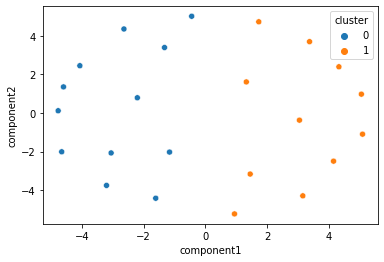

In [62]:
from sklearn.manifold import MDS
import seaborn as sns

embedding = MDS(n_components=2)
mds = pd.DataFrame(embedding.fit_transform(scaled_features.drop('cluster',axis=1)),
             columns = ['component1','component2'])
mds['cluster'] = kmeans_test.predict(scaled_features.drop('cluster',axis=1))

sns.scatterplot(data=mds,x = "component1",y="component2",hue="cluster")

As we can see, the classifier built a pretty accurate model. The sources from 0 to 12 belonged to one category, and others belonged to another.

In [63]:
mds

,component1,component2,cluster
0,-1.606637,-4.411820,0
1,-1.321465,3.392491,0
2,5.097683,-1.093368,1
3,0.946867,-5.224454,1
4,3.052930,-0.368376,1
5,4.157905,-2.491388,1
6,5.060786,0.978363,1
7,3.161510,-4.287667,1
8,1.733866,4.725638,1
9,3.379697,3.695959,1


In [41]:
import matplotlib.pyplot as plt

### Addition: Agglomerative Clustering

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram

# linkage is the the function that performs the clustering
Z = linkage(X, 
            method='single', 
            metric='euclidean')

In [49]:
# create string labels for the data samples, to show in the dendrogram
ticks = [f"id_type={el}" for i, el in enumerate(y)]

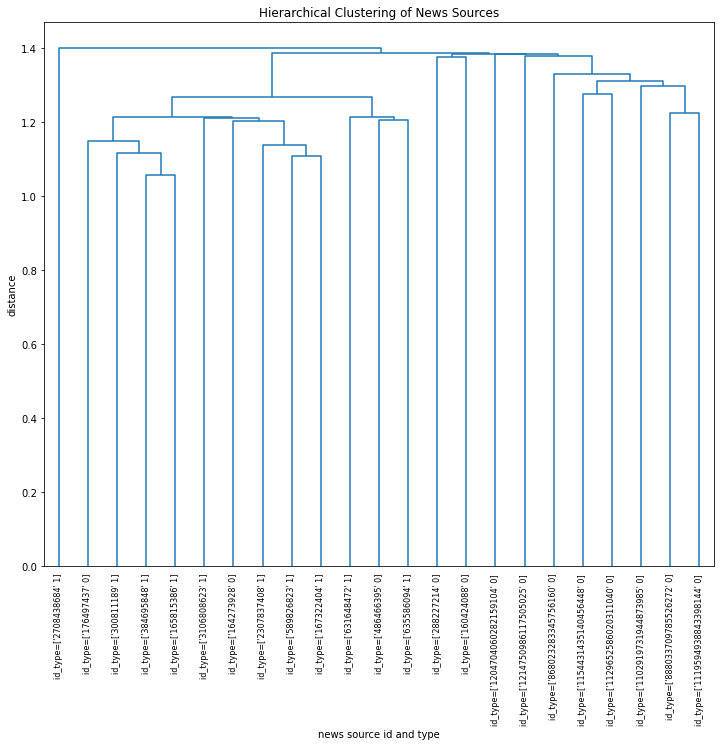

In [50]:
def draw_dendogram(Z, ticks):
    """Helper function to draw a dendogram for testing purposes.
    """
    plt.figure(figsize=(12, 10))
    plt.title('Hierarchical Clustering of News Sources')
    plt.xlabel('news source id and type')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels = ticks
    )

    plt.show()
    
    
draw_dendogram(Z, ticks)    

id: Twitter Id of the source  
type: 0 - independent source
      1 - governemnt-funded source

Clustering news sources by euclidean distance of Jaccard indeces resulted in 3 main brancehs: 2 big groups and 1 branch with only one source.

The news source that corresponds to the small branch is typically considered as a government-funded source @LiterKZ. With recent violent protests in Kazakhstan their page on Twitter haven't posted anything, but that must be due to the fact that there is an Internet blockage in the country.

The next branch is a big group of government-funded sources. However, 3 independent sources were missclassified: @Radio_Azattyk, @AzattyqRadiosy, @Vlastkz. These sources are actually one of the prominent independent news in Kazakhstan. I assume that they were missclustered, because they have a big number of followers. Most independent sources have a modest amount of follower in comparison to government-funded ones.

The third branch includes only independent sources.

#### Comparison between K-means and Agglomerative Clustering

The big independent news sources:  
        164273928 => @AzattyqRadiosy  
        486466395 => @Vlastkz  
        176497437 => @Radio_Azattyk  
were missclustered in groups with government funded sources in both Clusters.

And 2708438684 => @Literkz that had a separate branch, was clustered with independent sources, probably because of the small amount of followers.

### Task 6: Analysis

Looking at the results of the cluster model, turns out it can pretty accurately classify the news sources when using Jaccard Indices as features to determine the similarity between the sources.

However, the number of followers of independent and government-funded sources is very unbalanced, because independent sources had way less followers, so the similarity index between independent sources was very low.

To conclude, I was able to answer my research questions, because I was able to find out the popular news sources according to Twitter users, and classify the news sources by building a cluster.